In [1]:
%matplotlib inline


컴퓨터 비전(Vision)을 위한 전이학습(Transfer Learning)
=======================================================

이 강좌는 PyTorch [Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)의 [번역판](https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html)을 부분적으로 수정한 것이다.

이 튜토리얼에서는 전이학습(Transfer Learning)을 이용하여 이미지 분류를 위한
합성곱 신경망을 어떻게 학습시키는지 다룬다. 전이학습에 대해서는
[CS231n 노트](<http://cs231n.github.io/transfer-learning/>)에서 더 많은 내용을
읽어볼 수 있다.

위 노트를 인용해보면,

    실제로 충분한 크기의 데이터셋을 갖출수 있는 경우는 드물기 때문에,
    합성곱 신경망(Convolutional Network) 전체를 처음부터 학습하는 경우는 드물다. 
    대신, 매우 큰 데이터셋(예. 100가지 분류에 대해 120만개의 이미지가 포함된 ImageNet)에서 합성곱
    신경망(ConvNet)을 미리 학습한 후, 이 합성곱 신경망을 관심있는 작업을 위한 초기 설정 
    혹은 고정된 특징 추출기(fixed feature extractor)로 사용한다.

이러한 전이학습 시나리오의 주요한 2가지 방식은 다음과 같다:

-  **합성곱 신경망의 미세조정(finetuning)**: 무작위 초기화 대신, 신경망을
   ImageNet 1000 데이터셋 등으로 미리 학습한 신경망으로 초기화한다. 학습의 나머지
   과정들은 평상시와 같다.
-  **고정된 특징 추출기로써의 합성곱 신경망**: 여기서는 마지막의 완전히 연결
   된 계층을 제외한 모든 신경망의 가중치를 고정한다. 마지막의 완전히 연결된
   계층은 새로운 무작위의 가중치를 갖는 계층으로 대체되어 이 계층만 학습한다.


In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # 대화형 모드

데이터 불러오기
---------------

데이터를 불러오기 위해 `torchvision`과 `torch.utils.data` 패키지를 사용한다.

여기서 풀고자 하는 문제는 **개미**와 **벌**을 분류하는 모델을 학습하는 것이다.
개미와 벌 각각의 학습용 이미지는 대략 120장 정도 있고, 75개의 검증용 이미지가
있다. 일반적으로 맨 처음부터 학습을 한다면 이는 일반화하기에는 아주 작은
데이터셋이다. 하지만 우리는 전이학습을 할 것이므로, 일반화를 제법 잘 할 수 있을
것이다.

이 데이터셋은 ImageNet의 아주 작은 일부이다.

**Note :**
   데이터를 [여기](<https://download.pytorch.org/tutorial/hymenoptera_data.zip>)
   에서 다운로드 받아 적절한 디렉토리에 압축을 푼다. 이 강죄에서는 자신의 Google Drive에 데이터를 저장했다고 가정한다. 이를 위해서 먼저 Google Drive를 마운트하고 경로를 정의한다.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

MessageError: ignored

In [ ]:
data_dir = '/content/drive/MyDrive/DeepLearning2022/datasets/hymenoptera_data'

PyTorch는 적합한 형식으로 저장된 이미지 파일들을 하나의 `DataSet`으로 만들어주는 `datasets.ImageFolder` 클래스를 제공한다. 이것을 이용하면 커스텀 데이터셋 클래스를 작성하지 않아도 된다.

In [ ]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # data augmentation by random crop
        transforms.RandomHorizontalFlip(),  # data augmentation by flip
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## 일부 이미지 시각화하기

데이터 증가를 이해하기 위해 일부 학습용 이미지를 시각화해보자.



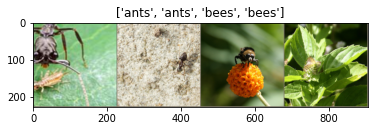

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

모델 학습하기
--------------

이제 모델을 학습하기 위한 일반 함수를 작성해보겠습니다. 여기서는 다음 내용들을
설명한다:

-  학습률(learning rate) 관리(scheduling)
-  최적의 모델 구하기

아래에서 ``scheduler`` 매개변수는 ``torch.optim.lr_scheduler`` 의 LR 스케쥴러
객체(Object)이다.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # save best model state
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정 why? batchnorm/dropout 등 레이어의 동작이 다름
            else:
                model.eval()   # 모델을 평가 모드로 설정 batchnorm: 지금까지의 train 평균치 사용, droupout 미사용

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

## 모델 예측값 시각화하기

일부 이미지에 대한 예측값을 보여주는 일반화된 함수이다.




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

합성곱 신경망 미세조정(finetuning)
----------------------------------

미리 학습한 모델을 불러온 후 마지막의 완전히 연결된 계층을 초기화한다.




In [ ]:
model_ft = models.resnet18(pretrained=True)

from torchsummary import summary
print(summary(model_ft, (3, 224, 224)))

print(dir(model_ft))
print(dir(model_ft.fc))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
num_ftrs = model_ft.fc.in_features

# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len(class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### 학습 및 평가하기


CPU에서는 15-25분 가량, GPU에서는 1분 이내의 시간이 걸린다.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5550 Acc: 0.7377
val Loss: 0.3185 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.4313 Acc: 0.8361
val Loss: 0.4336 Acc: 0.8366

Epoch 2/24
----------
train Loss: 0.3881 Acc: 0.8320
val Loss: 0.3766 Acc: 0.8431

Epoch 3/24
----------
train Loss: 0.5739 Acc: 0.7705
val Loss: 0.4549 Acc: 0.8431

Epoch 4/24
----------
train Loss: 0.4963 Acc: 0.8279
val Loss: 0.2767 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.2888 Acc: 0.9098
val Loss: 0.2372 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.6332 Acc: 0.7541
val Loss: 0.2842 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.3137 Acc: 0.8893
val Loss: 0.2586 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3455 Acc: 0.8811
val Loss: 0.2506 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3006 Acc: 0.8689
val Loss: 0.2993 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3516 Acc: 0.8607
val Loss: 0.3521 Acc: 0.8693

Epoch 11/24
----------
train Loss: 0.2577 Acc: 0.9098
val Loss: 0.2734 Acc: 0.9085

Ep

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


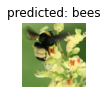

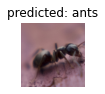

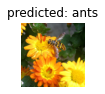

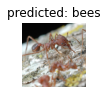

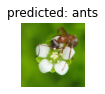

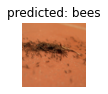

In [ ]:
visualize_model(model_ft)

고정된 특징 추출기로써의 합성곱 신경망
---------------------------------------

마지막 계층을 제외한 신경망의 모든 부분을 고정한다.
``requires_grad = False``로 설정하여 매개변수를 고정하여 ``backward()`` 중에
경사도가 계산되지 않도록 해야한다.

이에 대한 문서는
[여기](<http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>)
에서 확인할 수 있다.

(이전에는 모든 레이어를 finetuning했음, 이제는 마지막 변경된 레이어만 tune)



In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### 학습 및 평가하기

CPU에서 실행하는 경우 이전과 비교했을 때 약 절반 가량의 시간만이 소요될 것이다.
이는 대부분의 신경망에서 경사도를 계산할 필요가 없기 때문이다. 하지만,
순전파는 계산이 필요하다.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6145 Acc: 0.6475
val Loss: 0.5711 Acc: 0.7124

Epoch 1/24
----------
train Loss: 0.4389 Acc: 0.8156
val Loss: 0.2617 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.5352 Acc: 0.7623
val Loss: 0.1855 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.6119 Acc: 0.7541
val Loss: 0.1736 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.4425 Acc: 0.7992
val Loss: 0.1920 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.3534 Acc: 0.8361
val Loss: 0.2868 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.3954 Acc: 0.8320
val Loss: 0.2678 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3399 Acc: 0.8689
val Loss: 0.1892 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.2799 Acc: 0.8811
val Loss: 0.1726 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.2977 Acc: 0.8484
val Loss: 0.1761 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3491 Acc: 0.8402
val Loss: 0.1775 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3348 Acc: 0.8484
val Loss: 0.1761 Acc: 0.9477

Ep

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

더 배워볼 내용
-----------------

전이학습의 응용 사례(application)들을 더 알아보려면 [문서](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html)를 참조하라.



